In [81]:
import tensorflow as tf
import keras
import keras_tuner as kt
import sqlite3
import imghdr
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import numpy as np

## Getting the data
Our data is stored in a SQlite database. We will use the `sqlite3` library to interact with the database.

### Load data from database

In [82]:
# Open db connection
conn = sqlite3.connect("testDB.db")
cursor = conn.cursor()

In [83]:
# Get results from db
cursor.execute(f"SELECT path, price FROM Dish WHERE price >= 10 AND price NOT LIKE '%+%'")
items = cursor.fetchall()

In [84]:
# Close db connection
cursor.close()
conn.close()

In [85]:
# Convert to pandas dataframe
items = df(items, columns=["path", "price"])
items

,path,price
0,Images!/1.jpg,13.79
1,Images!/2.jpg,14.79
2,Images!/23.jpg,10.29
3,Images!/24.jpg,10.29
4,Images!/25.jpg,10.29
...,...,...
1715,Images!/3687.jpg,13.95
1716,Images!/3688.png,12.95
1717,Images!/3689.jpg,13.95
1718,Images!/3690.jpg,14.50


In [86]:
# Remove rows where file is type TF can't read
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"] # https://stackoverflow.com/a/68192520
items = items[items["path"].apply(lambda x: imghdr.what(x) in img_type_accepted_by_tf)]
items

,path,price
0,Images!/1.jpg,13.79
1,Images!/2.jpg,14.79
2,Images!/23.jpg,10.29
3,Images!/24.jpg,10.29
4,Images!/25.jpg,10.29
...,...,...
1715,Images!/3687.jpg,13.95
1716,Images!/3688.png,12.95
1717,Images!/3689.jpg,13.95
1718,Images!/3690.jpg,14.50


In [87]:
# Shuffle the data
items = items.sample(frac=1)
items

,path,price
1005,Images!/2215.jpg,44.00
1468,Images!/3129.jpg,12.50
1575,Images!/3285.jpg,14.95
1146,Images!/2501.jpg,12.95
1696,Images!/3668.jpg,14.95
...,...,...
702,Images!/1712.jpg,14.50
285,Images!/710.png,12.00
871,Images!/2034.jpg,12.25
557,Images!/1374.jpg,48.00


### Create dataset
Now that we have the data from the database, we will create a dataset that we can use to train our model. This dataset will consist of the following columns:
- `path`: The path to the image file, which will be our feature
- `price`: The price of the image, which will be our target variable

In [88]:
# https://stackoverflow.com/a/75288145
def load_image(file_name):
    raw = tf.io.read_file(file_name)
    tensor = tf.io.decode_image(raw, expand_animations = False, channels = 3)
    tensor = tf.cast(tensor, tf.float32)
    return tensor

def create_dataset(file_names, labels):
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    dataset = dataset.map(lambda file_name, label: (load_image(file_name), label))
    return dataset

file_names = items['path'].to_numpy()
labels = items['price'].to_numpy()
dataset = create_dataset(file_names, labels)
dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

### Data splitting
We will split our data into training and testing sets. We will use 80% of the data for training and 20% for testing. We'll use 20% of the training data for validation, the remaining 80% will be used for training.

In [89]:
# Split the data into training (80%) and test (20%), then split training into training (80%) and validation (20%) of the training data
dataset.shuffle(dataset.cardinality())
test_prices = dataset.take(dataset.cardinality() // 5)
train_prices = dataset.skip(dataset.cardinality() // 5)
val_prices = train_prices.take(train_prices.cardinality() // 5)
train_prices = train_prices.skip(train_prices.cardinality() // 5)

test_prices.cardinality(), val_prices.cardinality(), train_prices.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=343>,
 <tf.Tensor: shape=(), dtype=int64, numpy=275>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1101>)

In [90]:
# Reshape images
image_dim = 256
size = (image_dim, image_dim)
train_ds = train_prices.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = val_prices.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_prices.map(lambda x, y: (tf.image.resize(x, size), y))

train_ds.cardinality(), validation_ds.cardinality(), test_ds.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=1101>,
 <tf.Tensor: shape=(), dtype=int64, numpy=275>,
 <tf.Tensor: shape=(), dtype=int64, numpy=343>)

In [91]:
# We'll also setup prefetching so that we can more easily load the data for training/testing
batch_size = 16
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

train_ds.cardinality(), validation_ds.cardinality(), test_ds.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=69>,
 <tf.Tensor: shape=(), dtype=int64, numpy=18>,
 <tf.Tensor: shape=(), dtype=int64, numpy=22>)

## Building the model
We'll load the Xception model trained on Imagenet data. However we'll explicity drop the fully connected layers so we can add our own (seen in the `include_top=False` line). Then, we'll add our own fully connected layers to the model. Then, we'll use hyperparameter optimization to find the best hyperparameters for the model. Finally, we'll train the model on the data.

In [92]:
def price_model(hp):
    # From Keras we load the Xception model
    base_model = keras.applications.Xception(
        weights="imagenet",  # load the model with weights from training on ImageNet
        input_shape=(image_dim, image_dim, 3), 
        include_top=False, # This states we won't include the "top" layers (the classifier)
    )

    # We can freeze the weights of any model/layer so they won't be updated when training the model
    base_model.trainable = False

    # With the base model defined we can create a regular Keras sequential model
    inputs = keras.Input(shape=(image_dim, image_dim, 3))
    # This version of the Xception model expects inputs to be scaled from (0, 255) to a range of (-1., +1.)
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)

    # The base model contains batchnorm layers, by setting training=False here it'll prevent those from being modified
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)

    hp_dense_1 = hp.Int('dense_1', min_value=60, max_value=256, step=20)
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.05)
    x = keras.layers.Dense(hp_dense_1, activation='relu')(x)
    x = keras.layers.Dropout(hp_dropout_1)(x)

    hp_dense_2 = hp.Int('dense_2', min_value=60, max_value=256, step=20)
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.3, step=0.05)
    x = keras.layers.Dense(hp_dense_2, activation='relu')(x)
    x = keras.layers.Dropout(hp_dropout_2)(x)

    hp_dense_3 = hp.Int('dense_3', min_value=60, max_value=256, step=20)
    hp_dropout_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.3, step=0.05)
    x = keras.layers.Dense(hp_dense_3, activation='relu')(x)
    x = keras.layers.Dropout(hp_dropout_3)(x)

    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.MeanSquaredError(),
    )

    return model

### Hyperparameter Search
Now that we have our model, we will use hyperparameter optimization to find the best hyperparameters for the model.

In [93]:
model = kt.Hyperband(price_model,
                     objective='val_loss',
                     max_epochs=15,
                     factor=3,
                     seed=10,
                     directory='hpm',
                     project_name='eatable_model',
                     overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.search(train_ds, validation_data=validation_ds, callbacks=[stop_early])

best_hps = model.get_best_hyperparameters(num_trials=1)[0]
model = model.hypermodel.build(best_hps)
model.summary(), best_hps.values

Trial 30 Complete [00h 02m 42s]
val_loss: 317.0011901855469

Best val_loss So Far: 200.22720336914062
Total elapsed time: 01h 10m 21s


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 160)            │       327,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 120)            │        19,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │        14,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,223,281 (80.96 MB)

 Trainable params: 361,801 (1.38 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

(None,
 {'dense_1': 160,
  'dropout_1': 0.25,
  'dense_2': 120,
  'dropout_2': 0.1,
  'dense_3': 120,
  'dropout_3': 0.15000000000000002,
  'learning_rate': 0.01,
  'tuner/epochs': 15,
  'tuner/initial_epoch': 5,
  'tuner/bracket': 1,
  'tuner/round': 1,
  'tuner/trial_id': '0018'})

### Training the model
Now that we have the best hyperparameters we can train the model

In [94]:
epochs = best_hps.values['tuner/epochs']
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 80s 822ms/step - loss: 1031.0493 - val_loss: 396.9942
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 240ms/step - loss: 780.3665 - val_loss: 331.7331
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step - loss: 801.3062 - val_loss: 295.8678
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 219ms/step - loss: 727.5757 - val_loss: 367.4797
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step - loss: 631.4650 - val_loss: 238.4099
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - loss: 501.8147 - val_loss: 600.3463
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - loss: 510.2677 - val_loss: 245.0781
Epoch 8/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - loss: 614.8667 - val_loss: 674.4677
Epoch 9/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - loss: 674.8064 - val_loss: 284.7957
Epoch 10/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - loss: 575.1312 - val_loss: 369.1873
Epoch 11/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - loss: 662.1107 - val_loss: 285.1

## Evaluating the model, simple

In [95]:
# Evaluate the model
model.evaluate(test_ds)

22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 636ms/step - loss: 613.7927


750.0768432617188

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


2024-04-21 19:45:39.126304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


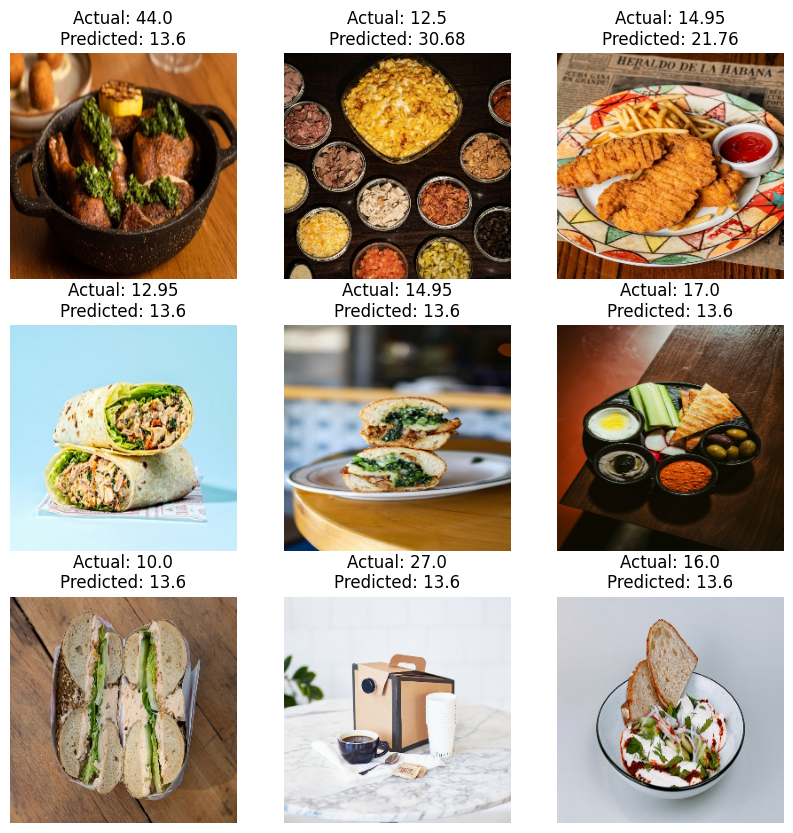

In [96]:
plt.figure(figsize=(10, 10))
for ix, (images, labels) in enumerate(test_ds.take(1)):
    model_preds = model.predict(images)
    model_labels = np.where(model_preds>0, model_preds, 0)
    for iy in range(9):
        ax = plt.subplot(3, 3, iy + 1)
        plt.imshow(np.array(images[iy]).astype(int))
        plt.title(f"Actual: {(labels[iy])}\nPredicted: {round(float(model_labels[iy][0]), 2)}")
        plt.axis("off")

## Saving the model
Now that we have trained the model, we will save it to disk so that we can use it later (i.e. in a web application).

In [97]:
model.save("models/eatable_model_reg.keras")

## Evaluating the model: accuracy within margin
Now that we've peeked at the model's performance, let's take a deeper look at how well it's doing.

First, let's see how accurate the model is at predicting a price within a certain range of the actual price.

In [98]:
# Get the test data
test_images = []
test_labels = []
for images, labels in test_ds:
    test_images.extend(images)
    test_labels.extend(labels)

2024-04-21 19:45:40.578717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [99]:
# Load the model
model = keras.models.load_model("models/eatable_model_reg.keras")

# Reshape the images
test_images = np.array(test_images)
test_images = test_images.reshape(len(test_images), image_dim, image_dim, 3)

# Predict the prices
predictions = model.predict(test_images)

11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step 


In [100]:
# Calculate correct predictions, at different margins (between min and max margins)
total = len(test_labels)
min_margin = 0
max_margin = 20
correct = []
for margin in range(min_margin, max_margin+1):
    acc = len([1 for i in range(total) if abs(test_labels[i] - predictions[i]) <= margin]) / total
    correct.append(acc)
    print(f"Accuracy within ${margin}.00 of the actual price: {round(acc*100,2)}%")

Accuracy within $0.00 of the actual price: 0.0%
Accuracy within $1.00 of the actual price: 18.08%
Accuracy within $2.00 of the actual price: 34.11%
Accuracy within $3.00 of the actual price: 44.31%
Accuracy within $4.00 of the actual price: 56.85%
Accuracy within $5.00 of the actual price: 60.35%
Accuracy within $6.00 of the actual price: 64.72%
Accuracy within $7.00 of the actual price: 67.64%
Accuracy within $8.00 of the actual price: 68.51%
Accuracy within $9.00 of the actual price: 71.43%
Accuracy within $10.00 of the actual price: 73.76%
Accuracy within $11.00 of the actual price: 75.22%
Accuracy within $12.00 of the actual price: 78.72%
Accuracy within $13.00 of the actual price: 80.76%
Accuracy within $14.00 of the actual price: 81.34%
Accuracy within $15.00 of the actual price: 83.09%
Accuracy within $16.00 of the actual price: 83.97%
Accuracy within $17.00 of the actual price: 85.42%
Accuracy within $18.00 of the actual price: 86.01%
Accuracy within $19.00 of the actual price:

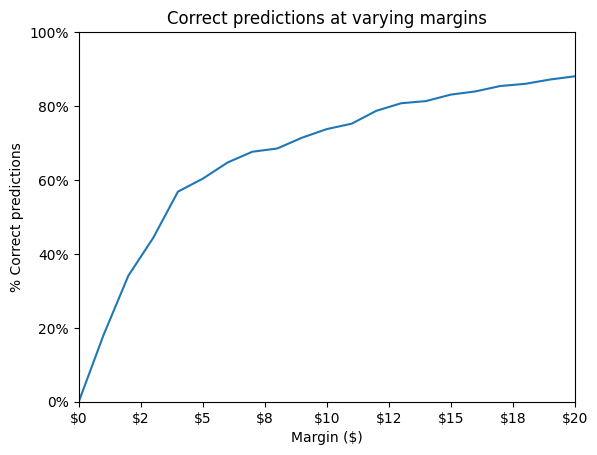

In [101]:
# Plot the results
plt.plot(range(min_margin, max_margin+1), correct)

# x-axis
plt.xlabel("Margin ($)")
plt.xlim(min(0, min_margin), max_margin)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x:.0f}"))

# y-axis
plt.ylabel("% Correct predictions")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

plt.title("Correct predictions at varying margins")
plt.show()